<a href="https://colab.research.google.com/github/SaifurShatil/Machine-Learning/blob/main/GRIP_Task_2_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The Sparks Foundation-GRIP-Data Science and Business Analytics-August'2021
### Task 2: Color Identification in Images
### Author: Saifur Rahman Shatil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Importing Libaries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import Counter
from skimage.color import rgb2lab
from sklearn.cluster import KMeans
import os
%matplotlib inline

#### Working with OpenCV

Input type: <class 'numpy.ndarray'>
Shape: (501, 334, 3)


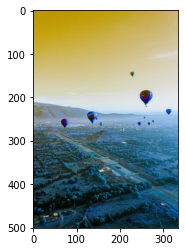

In [ ]:
image=cv2.imread('/content/drive/MyDrive/Colab Notebooks/Color Identification using ML/sample_image.jpg')
print("Input type: {}".format(type(image)))
print("Shape: {}".format(image.shape))
plt.imshow(image)

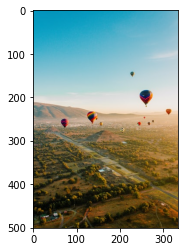

In [ ]:
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB) # Convert to RGB
plt.imshow(image)

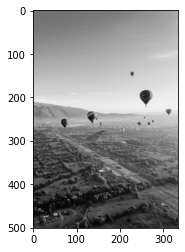

In [ ]:
gray_image= cv2.cvtColor(image,cv2.COLOR_RGB2GRAY) # Grayscale image
plt.imshow(gray_image,cmap='gray')

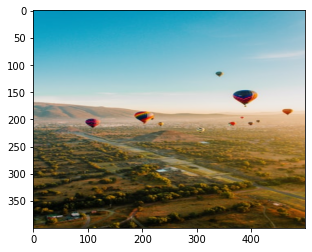

In [ ]:
resized_image= cv2.resize(image,(500,400)) # Resize
plt.imshow(resized_image)

In [ ]:
modified_image = cv2.resize(image, (500, 400), interpolation = cv2.INTER_AREA)
modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)

In [ ]:
from sklearn.cluster import KMeans
wcss=[]
for i in range(1,15):
    kmeans= KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=100,random_state=0,n_jobs=-1,verbose=True)
    kmeans.fit(modified_image)
    wcss.append(kmeans.inertia_)

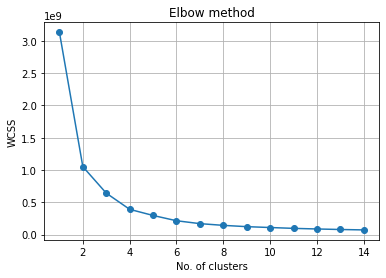

In [ ]:
plt.plot(range(1,15),wcss,marker='o')
plt.title("Elbow method")
plt.xlabel("No. of clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

#### Color Identification

In [ ]:
# returns hex values of our the colors
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [ ]:
# Read and convert image to rgb
def get_image(image_path):
  image=cv2.imread(image_path)
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  return image

In [ ]:
#get_image('/content/drive/MyDrive/Colab Notebooks/Color Identification using ML/sample_image.jpg')

KMeans expects flattened array as input during its fit method. Thus, we need to reshape the image using numpy. Then, we can apply KMeans to first fit and then predict on the image to get the results. Then, the cluster colors are identified an arranged in the correct order. We plot the colors as a pie chart.

In [ ]:
def get_colors(image, number_of_colors, show_chart):
    # Resize and convert image to 1d array
    modified_image = cv2.resize(image, (500, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    # model training
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    # Get Hex Color values
    counts = Counter(labels)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]
    
    #print(hex_colors)

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(),labels=hex_colors,colors=hex_colors)
    
    return rgb_colors

[array([161.50917271, 202.67230346, 212.5641314 ]),
 array([95.75245365, 75.3067266 , 31.94419768]),
 array([ 98.48453651, 181.80210885, 204.77533314]),
 array([146.56247752, 116.82045954,  65.15908092]),
 array([41.13287111, 35.28262326, 13.44764871]),
 array([191.82678638, 162.57388702, 130.60044893]),
 array([ 25.14647494, 161.84376006, 195.48567443]),
 array([220.39871159, 221.71641856, 216.46617916])]

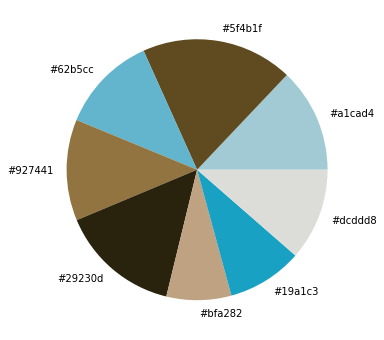

In [ ]:
# Showing colors in an image in pie chart
get_colors(get_image('/content/drive/MyDrive/Colab Notebooks/Color Identification using ML/sample_image.jpg'), 8, True)

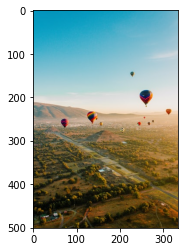

In [ ]:
plt.imshow(get_image('/content/drive/MyDrive/Colab Notebooks/Color Identification using ML/sample_image.jpg'))

#### Search Images Using Color

In [ ]:
colors={
    'GREEN': [0,128,0],
    'BLUE': [0,0,128],
    'YELLOW': [230,106,26],
    'WHITE': [255,255,255],
    'BLACK': [0,0,0],
    'RED': [255,0,0]
}

#### Load and show images in directory 

In [ ]:
image_dir='/content/drive/MyDrive/Colab Notebooks/Color Identification using ML/Images'

images=[]

for img in os.listdir(image_dir):
  if not img.startswith('.'):
    images.append(get_image(os.path.join(image_dir,img)))


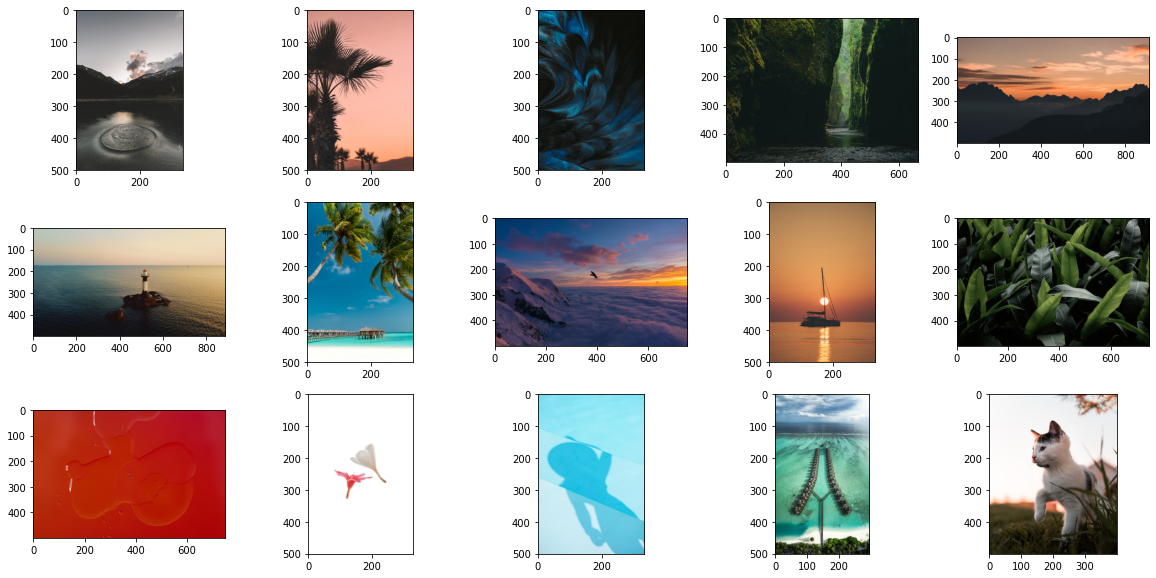

In [ ]:
plt.figure(figsize=(20,10))
for i in range(len(images)):
  rows= len(images)//5
  plt.subplot(rows,5,i+1)
  plt.imshow(images[i])

#### Match Image Color with Given Input Color

We define the function below. We will try to match with the top 10 colors of the image. It is highly possible that there will be no extact match for the hex codes, thus we calculate the similarity between the chosen color and the colors of the image. 

We keep a threshold value such that if the difference between the chosen color and any of the selected colors is less than that threshold, we declare it as a match.

Hex values or RGB values cannot be directly compared so we first convert them to a device independant and color uniform space. We use `rgb2lab` to convert the values and then find the difference using `deltaE_cie76`. The method calculates the difference between all top 5 colors of the image and the selected color and if atleast one is below the threshold, we show the image.

In [ ]:
from skimage.color import deltaE_cie76

In [ ]:
def match_image_by_color(image,color,threshold=60,number_of_colors=10):
  image_colors=get_colors(image,number_of_colors,False)
  selected_color=rgb2lab(np.uint8(np.asarray([[color]])))
  select_image=False
  for i in range(number_of_colors):
    current_color= rgb2lab(np.uint8(np.asarray([[image_colors[i]]])))
    diff= deltaE_cie76(selected_color,current_color)
    if diff<threshold:
      select_image=True
  return select_image


In [ ]:
def show_selected_images(images,color,threshold,colors_to_match):
  index=1
  for i in range(len(images)):
    selected= match_image_by_color(images[i],color,threshold,colors_to_match)
    if selected:
      row=len(images)//5
      plt.subplot(row,5,index)
      plt.imshow(images[i])
      index+=1

#### Show matched images

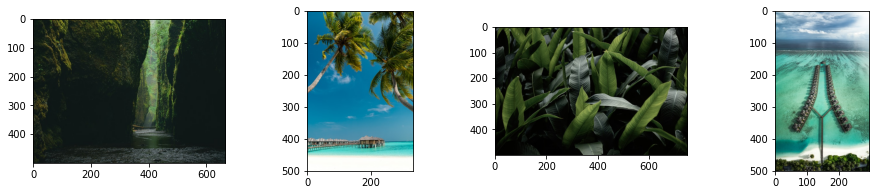

In [ ]:
# Search for green
plt.figure(figsize=(20,10))
show_selected_images(images,colors['GREEN'],60,5)

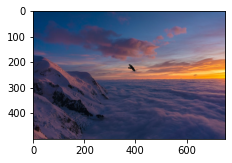

In [ ]:
# Search For Blue
plt.figure(figsize=(20,10))
show_selected_images(images,colors['BLUE'],60,5)

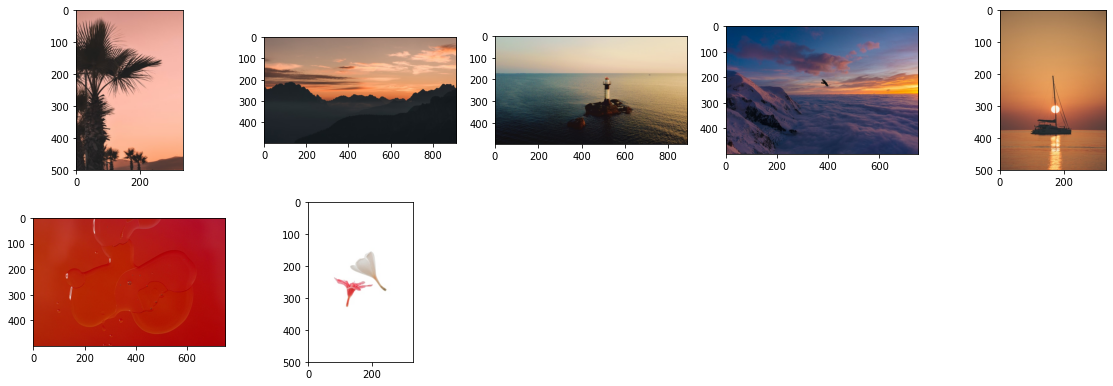

In [ ]:
# Search For Yellow
plt.figure(figsize=(20,10))
show_selected_images(images,colors['YELLOW'],60,5)

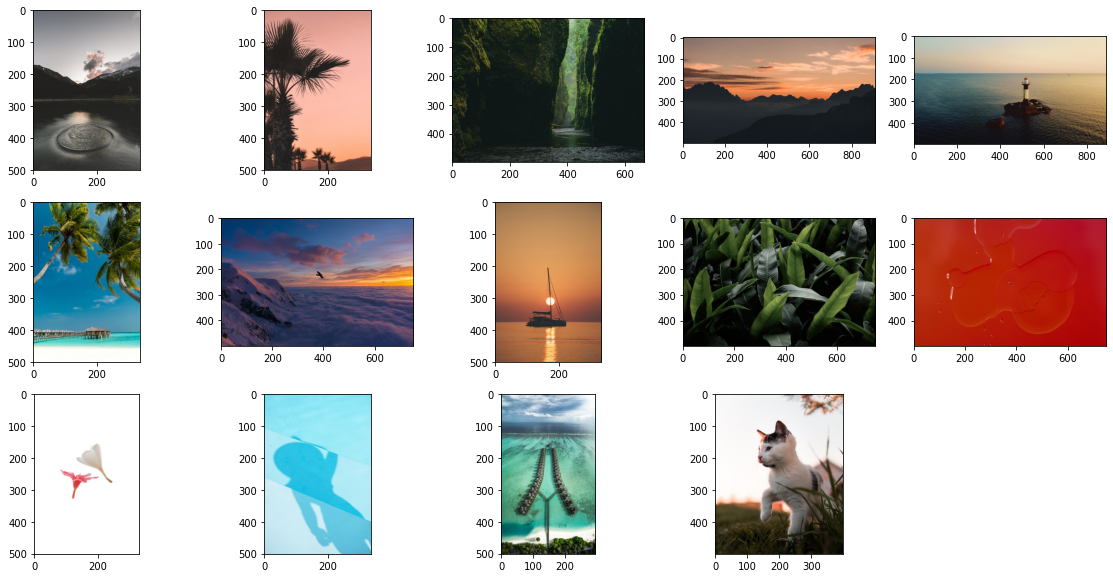

In [ ]:
# Search For White
plt.figure(figsize=(20,10))
show_selected_images(images,colors['WHITE'],60,5)

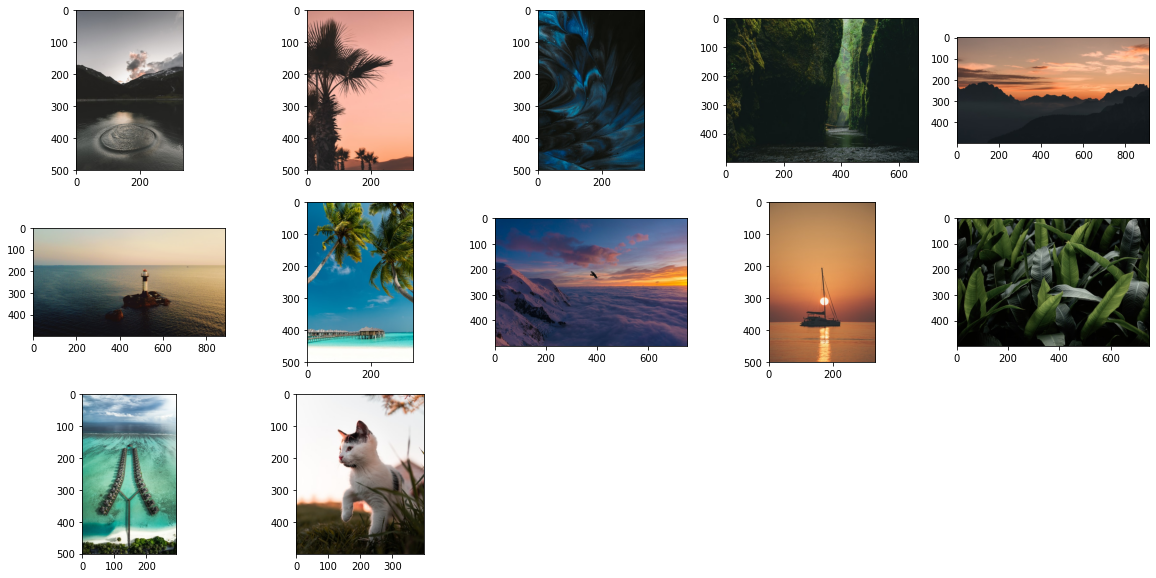

In [ ]:
# Search For Black
plt.figure(figsize=(20,10))
show_selected_images(images,colors['BLACK'],60,5)

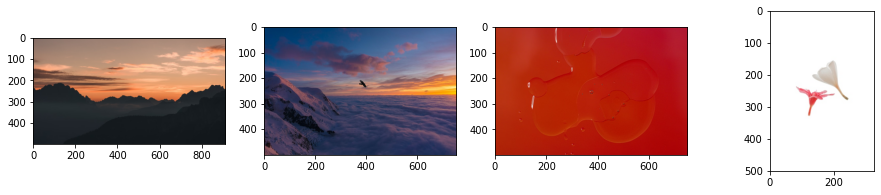

In [ ]:
# Search For RED
plt.figure(figsize=(20,10))
show_selected_images(images,colors['RED'],60,5)

#### Conclusion
We implemented KMeans to extract majority colors from images and then used these rgb colors to identify images